<a href="https://colab.research.google.com/github/otoperalias/Coyuntura/blob/main/clases/Tema2_IV.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

## Coyuntura en el mercado laboral

En este notebook vamos a usar datos del mercado laboral para aprender a crear un informe de coyuntura. Como ejemplo, vamos hacer un informe de coyuntura para Sevilla.

### Fuentes estadísticas:
* INE. En la sección de [Mercado Laboral](https://www.ine.es/dyngs/INEbase/es/categoria.htm?c=Estadistica_P&cid=1254735976594), cabe destacar las siguientes estadísticas para el análisis de coyuntura:
  * [Encuesta de Población Activa (EPA)](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176918&menu=ultiDatos&idp=1254735976595).
  * [Encuesta trimestral de coste laboral](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736045053&menu=ultiDatos&idp=1254735976596).
* Ministerio de Trabajo:
  * [Estadística del Movimiento Laboral Registrado](https://www.mites.gob.es/es/estadisticas/mercado_trabajo/MLR/welcome.htm).
* Seguridad Social:
  * [Afiliaciones a la Seguridad Social](https://www.seg-social.es/wps/portal/wss/internet/EstadisticasPresupuestosEstudios/Estadisticas/EST8).

*Para interpretar correctamente las variables, es fundamental conocer bien la metodología, en particular, qué miden exactamente. Así, no es comparable el concepto de "parado registrado" con el de "parado" de la EPA.*


### Diseño del informe.

Para realizar el informe, primero tenemos que decidir qué variables queremos mostrar en el mismo. Dada la disponibilidad de datos a nivel provincial, vamos a incluir las siguientes variables en nuestro informe:
1. Tasa de paro.
2. Tasa de actividad y de ocupación.
3. Volumen de afiliaciones a la Seguridad Social y su tasa de variación.
4. Número de parados registrados y su tasa de variación.
  
En segundo lugar, tenemos que decidir el formato del informe. Para ello, es útil dibujar un borrador en un papel y así decidir el mejor diseño posible.  
En este caso, vamos a crear un informe breve, con la extensión de una página A4. Lo vamos a hacer enteramente en ```matplotlib```. Vamos a estructurar en informe en una figura de 6 axes (3 filas x 2 columnas). Los primeros 5 axes van a contener gráficos, mientras el último una tabla.

### Importamos librerías y datos:

In [1]:
import pandas as pd
pd.set_option('display.max_row',50)
pd.set_option('display.max_columns', 20)
import matplotlib.pyplot as plt

#### Series de la EPA
En [EPA](https://www.ine.es/dyngs/INEbase/es/operacion.htm?c=Estadistica_C&cid=1254736176918&menu=ultiDatos&idp=1254735976595), hacemos clic en la siguiente secuencia: Resultados => Series desde el primer trimestre de 2002 => Resultados provinciales => Población en viviendas familiares (incluye parados) => Tasas de actividad, paro y empleo por provincia y sexo.  
Entonces, hacemos la selección deseada: las tres tasas, Ambos sexos, Total Nacional y Sevilla, todos los periodos (ordenándolos haciendo clic en a/z) y le damos a la tabla el formato deseado (con los periodos en las filas).  
Posteriormente, descargo el archivo en el formato "Excel: extensión XLSx", con el nombre de EPA_Sevilla, en cual lo subo a Google Colab y procedo a importar.

In [2]:
epa=pd.read_excel("EPA_Sevilla.xlsx")

/usr/local/lib/python3.10/dist-packages/openpyxl/styles/stylesheet.py:226: UserWarning: Workbook contains no default style, apply openpyxl's default
  warn("Workbook contains no default style, apply openpyxl's default")


Tras explorar brevemente la tabla (```epa[:20]```, ```epa[-20:]```), vemos que tenemos que hacer el siguiente procesamiento:

In [ ]:
# 1. Nombrar cada columna de manera apropiada
epa.rename(columns={"Unnamed: 1":"TA_esp",
                    "Unnamed: 2":"TA_sev",
                    "Unnamed: 3":"TP_esp",
                    "Unnamed: 4":"TP_sev",
                    "Unnamed: 5":"TE_esp",
                    "Unnamed: 6":"TE_sev"}, inplace=True)
# 2. Seleccionar las filas con datos (de index=8 a =93):
epa=epa.iloc[8:94] # Hay que poner 94, porque la última no se incluye

# 3. Crear una columna con el periodo, para convertirla en datetime y en el index.
epa['periodo']=epa['Resultados provinciales'].str[:4]+"Q"+epa['Resultados provinciales'].str[-1:]
epa['periodo']=pd.to_datetime(epa['periodo'])
epa.set_index('periodo', inplace=True)

# 4. Borramos columnas innecesarias
epa.drop(columns='Resultados provinciales', inplace=True)

In [ ]:
# Podemos dibujar un gráfico para ver que está todo bien.
epa.plot()

#### Parados registrados

Los datos de demandantes de empleo parados (es decir, de parados registrados) están disponibles en [este enlace](https://www.sepe.es/HomeSepe/que-es-el-sepe/estadisticas/empleo/estadisticas-nuevas.html). Como puede apreciarse, es muy tedioso descargar mes a mes, aunque podría hacerse.  
Para que aprendáis cómo podría hacerse mecánicamente, a continuación procedemos a extraer los datos necesarios directamente en Python.


In [ ]:
# i. CREAMOS UN BUCLE PARA EXTRAER LOS DATOS DESEADOS

meses={'enero':"01",'febrero':"02",'marzo':"03",'abril':"04",'mayo':"05",'junio':"06",'julio':"07",'agosto':"08",'septiembre':"09",'octubre':"10",'noviembre':"11",'diciembre':"12"}
years=["2021","2022","2023"]

preg_fecha=[]
preg_sev=[]
preg_esp=[]

for year in years:
  for mes in meses:
    link="https://www.sepe.es/SiteSepe/contenidos/que_es_el_sepe/estadisticas/datos_estadisticos/empleo/datos/"+year+"/"+mes+"_"+year+"/ESTADISTICA-DE-EMPLEO.xls"
    preg=pd.read_excel(link,sheet_name="6.2")
    fecha=year+"-"+meses[mes]
    sev=preg.loc[preg["Unnamed: 1"]=="SEVILLA","Unnamed: 2"].iloc[0]
    esp=preg.loc[preg["Unnamed: 1"]=="TOTAL ZONA GEOGRAFICA","Unnamed: 2"].iloc[0]
    preg_fecha.append(fecha)
    preg_sev.append(sev)
    preg_esp.append(esp)
    if fecha=="2023-09":
      break

# ii. CREAMOS UNA DATAFRAME A PARTIR DE LAS LISTAS

diccionario={'fecha':preg_fecha,'sev':preg_sev, 'esp':preg_esp}
parados=pd.DataFrame(diccionario)

# iii. CONVERTIMOS LA FECHA EN "DATETIME" Y LO ESTABLECEMOS COMO INDEX
parados['fecha']=pd.to_datetime(parados['fecha'])
parados.set_index("fecha", inplace=True)

In [ ]:
# Podemos dibujar un gráfico para ver que está todo bien.
parados.plot()

#### Datos de afiliados a la SS

En la página de las [estadísticas de afiliaciones](https://www.seg-social.es/wps/portal/wss/internet/EstadisticasPresupuestosEstudios/Estadisticas/EST8), hacemos click en la siguiente secuencia: Series PX-Web => Afiliados en alta laboral => Afiliados Fin de mes => 04f. Por provincia, seccion de actividad y regimen (RG y RETA) (Ultimo dia).  
En este caso, los datos se pueden descargar cómodamente: seleccionamos todos los periodos, Total Nacional y Sevilla, "Total Regímenes" y Todas las secciones. Clicamos en CONTINUAR y luego hacemos clic en "Pivotación manual", para poner los periodos en las filas y los datos de España y Sevilla en las columnas.  
Finalmente, en la barra de la izquierda, clicamos en **Grabar el resultados como...**, indicando *Excel formato ( csv)* y con el nombre "Afiliados_Sevilla".

In [ ]:
ss=pd.read_csv("Afiliados_Sevilla.csv", sep=";",skiprows=1)
ss

Observamos que solo hay que poner la columna periodo en formato adecuado para establecerlo como datetime y posteriormente como index de la tabla. También parece conveniente renombrar las columnas, con nombres más cortos.

In [38]:
# Primero: convertimos la columna en string
ss['Periodo']=ss['Periodo'].astype(str)
# Segundo: le damos formato
ss['Periodo']=ss['Periodo'].str[:4]+"-"+ss['Periodo'].str[-2:]
# Tercero: convertimos en datetime
ss['Periodo']=pd.to_datetime(ss['Periodo'])
# Cuarto: convertimos en index.
ss.set_index("Periodo", inplace=True)
# Quinto: renombramos columnas
ss.rename(columns={'Total Regimenes(RG+RETA) TODAS LAS SECCIONES Total Nacional':"esp",
                   'Total Regimenes(RG+RETA) TODAS LAS SECCIONES 41. Sevilla':"sev"},inplace=True)

<Axes: xlabel='Periodo'>

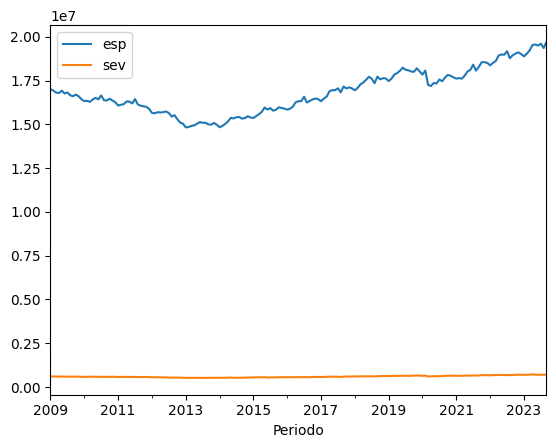

In [39]:
# Podemos dibujar un gráfico para ver que está todo bien.
ss.plot()

### Procesamos los datos que necesitamos

* Las tasas de paro, actividad y empleo ya vienen calculadas y, por tanto, no hay que hacer nada con ellas.
* Para parados registrados y afiliaciones, hay que calcular las tasas de variación interanuales.

In [41]:
parados_tv=(parados/parados.shift(12)-1)*100
ss_tv=(ss/ss.shift(12)-1)*100

Sobre todo cuando estamos aprendiendo a usar Python/Pandas, es conveniente comprobar que los cálculos son correctos:

In [47]:
# Tasa variación parados registrados Enero 2022, Sevilla:
print(189779/230652-1)
# Ídem en la nueva tabla:
print(parados_tv.loc["2022-01","sev"].iloc[0])


-0.1772063541612472
-0.1772063541612472


Ahora es necesario que preparemos la tabla que queremos incluir. La tabla va a mostrar los datos de los últimos 4 trimestres para Sevilla y España, para todas las variables.

